In [1]:
import numpy as np
from matplotlib import pyplot as plt
from tifffile import imread
from skimage.filters import threshold_multiotsu
import os
import porespy as ps
from tifffile import imwrite
from hydra.experimental import compose, initialize
from omegaconf import OmegaConf
import torch
from matplotlib import pyplot as plt
from tifffile import imread
import numpy as np
import pickle
from hydra.experimental import compose, initialize
import os
import torch
from lpu3dnet.frame import vqgan
from lpu3dnet.frame import transformer

import pandas as pd



def get_irr_sw(db):
    db = db[db['kr_water']<1e-05]
    return db['sw'].max()

def get_res_sw(db):
    db = db[db['kr_air']<1e-07]
    return db['snw'].max()

def process_kr_db(kr_db):
    kr_df = pd.DataFrame(
    {
    'snw':kr_db['snw'],
    'sw': kr_db['sw'],
    'kr_air':kr_db['kr_air'],
    'kr_water':kr_db['kr_water']
                      }
                      )
    
    sw_irr = get_irr_sw(kr_df)
    snw_res = get_res_sw(kr_df)
    db = kr_df[( (kr_df['sw']>=sw_irr) & (kr_df['snw']>=snw_res) )]
    return db,sw_irr,snw_res



def plot_figure_air(kr_results_real, kr_results_pred, kr_compare):
    f = plt.figure()

    # Using 'yo-' for yellow dots with a line, making the line thicker for visibility
    plt.plot(kr_results_real['snw'], kr_results_real['kr_air'], 'yo-', linewidth=3, label='real')

    for ensemble in kr_results_pred:
        # Using 'r*-' for red stars with a line, specifying a smaller line width
        plt.plot(ensemble['snw'], ensemble['kr_air'], 'r*:', linewidth=2, label='pred')

    # Plot comparison
    
    for compare in kr_compare:
        # Using 'g.' for gray dots, no connecting line, and specifying marker size for smaller appearance
        plt.plot(compare['snw'], compare['kr_air'], 'g.', color='gray', markersize=5, label='compare')

    plt.show()



def plot_figure_water(kr_results_real, kr_results_pred, kr_compare):
    f = plt.figure()

    # Using 'yo-' for yellow dots with a line, making the line thicker for visibility
    plt.plot(kr_results_real['snw'], kr_results_real['kr_water'], 'yo-', linewidth=3, label='real')

    for ensemble in kr_results_pred:
        # Using 'r*-' for red stars with a line, specifying a smaller line width
        plt.plot(ensemble['snw'], ensemble['kr_water'], 'r*:', linewidth=2, label='pred')


    for compare in kr_compare:
        # Using 'g.' for gray dots, no connecting line, and specifying marker size for smaller appearance
        plt.plot(compare['snw'], compare['kr_water'], 'g.', color='gray', markersize=5, label='compare')

    plt.show()

root_dir = 'db'

ct_idx = 1
vol_dim = 3
with open(f'{root_dir}/sample_{ct_idx}/phys_results_{vol_dim}_128.pickle', 'rb') as file:
    # Deserialize the data from the file and assign it to a variable
    sim_results = pickle.load(file)


In [13]:
print(len(sim_results['compare']))
print(len(sim_results[0]['generate']))
# print(len(sim_results['real']))

20
30


In [45]:
sample_idx = 0

process_db_compare = []
kr_compare = sim_results['compare']
sw_irr_list_compare = []
sw_res_list_compare = []
for kr_per_ensemble in kr_compare:
    if kr_per_ensemble:
        db,sw_irr,snw_res = process_kr_db(kr_per_ensemble)
        if db.empty:
            continue
        else:
            if len(db) > 4:
                process_db_compare.append(db)
                sw_irr_list_compare.append(sw_irr)
                sw_res_list_compare.append(snw_res)


upper_bound_swirr = max(sw_irr_list_compare)
lower_bound_swirr = min(sw_irr_list_compare)
upper_bound_swres = max(sw_res_list_compare)
lower_bound_swres = min(sw_res_list_compare)




process_db_pred = []
sw_irr_list_pred = []
sw_res_list_pred = []
kr_generate = sim_results[sample_idx]['generate']
for kr_per_ensemble in kr_generate:
    if kr_per_ensemble:
        db,sw_irr,snw_res = process_kr_db(kr_per_ensemble)
        if db.empty:
            continue
        if sw_irr > upper_bound_swirr or sw_irr < lower_bound_swirr:
            continue
        if snw_res > upper_bound_swres or snw_res < lower_bound_swres:
            continue
        else:
            if len(db) > 4:
                process_db_pred.append(db)
                sw_irr_list_pred.append(sw_irr)
                sw_res_list_pred.append(snw_res)


process_db_real, sw_irr, snw_res = process_kr_db(sim_results[sample_idx]['original'])


print(len(process_db_pred))
print(len(process_db_real))
print(len(process_db_compare))


def calculate_mse(pred_list,target_val):
    mse_list_total = 0
    for pred in pred_list:
        mse = abs(pred - target_val)
        mse_list_total += mse
    # average mse list
    mse_avg = mse_list_total/len(pred_list)
    return mse_avg
    

# calculate mse
mse_swir_pred = calculate_mse(sw_irr_list_pred,sw_irr)
mse_swir_compare = calculate_mse(sw_irr_list_compare,sw_irr)

# residual saturation
mse_swres_pred = calculate_mse(sw_res_list_pred,snw_res)
mse_swres_compare = calculate_mse(sw_res_list_compare,snw_res)


print('mse_swir_pred:',mse_swir_pred)
print('mse_swir_compare:',mse_swir_compare)
print (30*'---')
print('mse_swres_pred:',mse_swres_pred)
print('mse_swres_compare:',mse_swres_compare)






8
9
12
mse_swir_pred: 0.10880692539196983
mse_swir_compare: 0.06470477263574179
------------------------------------------------------------------------------------------
mse_swres_pred: 0.13373512253579603
mse_swres_compare: 0.20689272545262746


(0.0, 0.6)

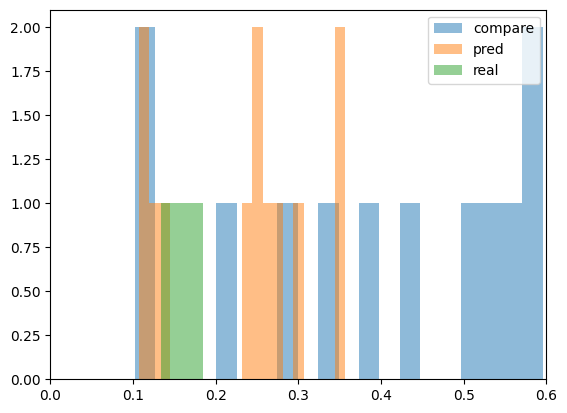

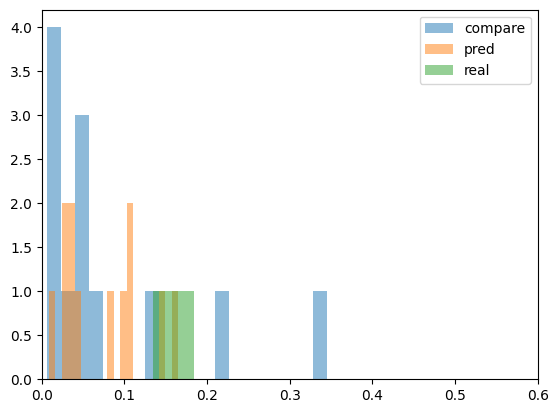

In [44]:
f = plt.figure()
plt.hist(sw_res_list_compare, bins=20, alpha=0.5, label='compare')
plt.hist(sw_res_list_pred, bins=20, alpha=0.5, label='pred')
plt.hist([snw_res], bins=20, alpha=0.5, label='real')
plt.legend(loc='upper right')
plt.xlim(0,0.6)

f = plt.figure()
plt.hist(sw_irr_list_compare, bins=20, alpha=0.5, label='compare')
plt.hist(sw_irr_list_pred, bins=20, alpha=0.5, label='pred')
plt.hist([snw_res], bins=20, alpha=0.5, label='real')
plt.legend(loc='upper right')
plt.xlim(0,0.6)

/tmp/ipykernel_1564701/2305272457.py:64: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g." (-> color='g'). The keyword argument will take precedence.
  plt.plot(compare['snw'], compare['kr_air'], 'g.', color='gray', markersize=5, label='compare')


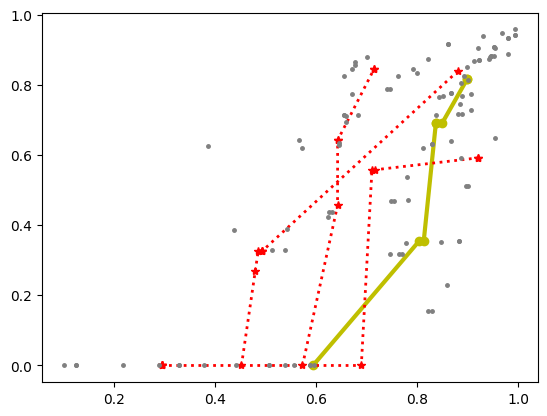

/tmp/ipykernel_1564701/2305272457.py:83: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "g." (-> color='g'). The keyword argument will take precedence.
  plt.plot(compare['snw'], compare['kr_water'], 'g.', color='gray', markersize=5, label='compare')


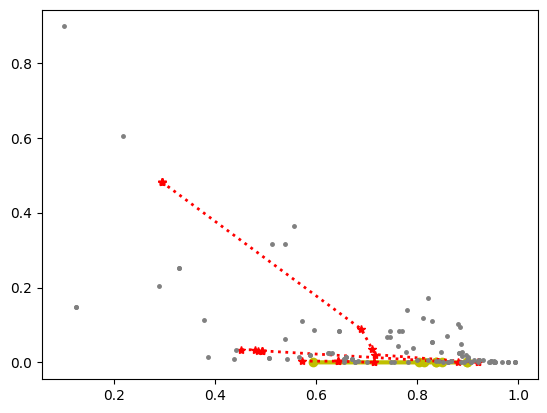

In [36]:
plot_figure_air(process_db_real, process_db_pred, process_db_compare)
plot_figure_water(process_db_real, process_db_pred, process_db_compare)



**extract and analyze irreducible saturation**

In [ ]:
def process_kr_db(kr_db):
    kr_df = pd.DataFrame(
    {
    'snw':kr_db['snw'],
    'sw': kr_db['sw'],
    'kr_air':kr_db['kr_air'],
    'kr_water':kr_db['kr_water']
                      }
                      )
    
    sw_irr = get_irr_sw(kr_df)
    snw_res = get_res_sw(kr_df)
    db = kr_df[( (kr_df['sw']>=sw_irr) & (kr_df['snw']>=snw_res) )]
    return db

In [34]:
sw_irr = get_irr_sw(kr_df)

,snw,sw,kr_air,kr_water
24,0.133934,0.866066,4.467072e-09,2.597911e-01
25,0.744437,0.255563,4.168805e-01,7.453013e-02
26,0.763728,0.236272,4.821501e-01,3.084553e-02
27,0.908003,0.091997,5.453938e-01,1.202766e-03
28,0.912175,0.087825,5.549073e-01,2.333206e-04
29,0.931757,0.068243,7.710387e-01,2.227917e-04
30,0.937306,0.062694,8.494759e-01,2.227628e-04
31,0.940325,0.059675,8.838493e-01,4.552576e-05
32,0.940325,0.059675,8.838493e-01,4.552576e-05
33,0.957143,0.042857,9.537980e-01,5.667611e-07
